In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import statsmodels.api as sm 
from scipy.stats import skew, kurtosis 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics       import r2_score, mean_absolute_error
from sklearn.pipeline      import Pipeline
from sklearn.model_selection import cross_val_predict, KFold

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
merged=pd.read_csv("merged_exact_weight.csv")
merged.shape

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/3995920293.py:1: DtypeWarning: Columns (133) have mixed types. Specify dtype option on import or set low_memory=False.
  merged=pd.read_csv("merged_exact_weight.csv")


(6079, 209)

In [3]:
# ─── 1) DICTS ────────────────────────────
brenner = {
    21: 410, 22: 480, 23: 530, 24: 640, 25: 740,
    26: 850, 27: 990, 28:1150, 29:1310, 30:1460,
    31:1630, 32:1810, 33:2010, 34:2220, 35:2430,
    36:2650, 37:2870, 38:3030, 39:3170, 40:3280,
    41:3360, 42:3410, 43:3420, 44:3390
}

who_general = {
    14:  90, 15: 114, 16: 144, 17: 179, 18: 222, 
    19: 272, 20: 330, 21: 398, 22: 476, 23: 565,
    24: 665, 25: 778, 26: 902, 27: 1039, 28: 1189,
    29: 1350, 30: 1523, 31: 1707, 32: 1901, 33: 2103,
    34: 2312, 35: 2527, 36: 2745, 37: 2966, 38: 3186,
    39: 3403, 40: 3617
}

who_female = {
    14:  89, 15: 113, 16: 141, 17: 176, 18: 217, 
    19: 266, 20: 322, 21: 388, 22: 464, 23: 551,
    24: 649, 25: 758, 26: 880, 27: 1014, 28: 1160,
    29: 1319, 30: 1489, 31: 1670, 32: 1861, 33: 2060,
    34: 2268, 35: 2481, 36: 2689, 37: 2917, 38: 3136,
    39: 3354, 40: 3567
}

who_male = {
    14:  92, 15: 116, 16: 146, 17: 183, 18: 226, 
    19: 277, 20: 337, 21: 407, 22: 487, 23: 578,
    24: 681, 25: 795, 26: 923, 27: 1063, 28: 1215,
    29: 1379, 30: 1555, 31: 1741, 32: 1937, 33: 2140,
    34: 2350, 35: 2565, 36: 2783, 37: 3001, 38: 3218,
    39: 3432, 40: 3639
}

intergrowth = {
    18: 216, 
    19: 263, 20: 318, 21: 381, 22: 454, 23: 537,
    24: 630, 25: 734, 26: 851, 27: 979, 28: 1119,
    29: 1272, 30: 1435, 31: 1610, 32: 1795, 33: 1988,
    34: 2189, 35: 2394, 36: 2602, 37: 2811, 38: 3017,
    39: 3217, 40: 3409, 41: 3588
}

## Interpolates 

In [4]:
# ─── A) Build an interpolation factory ───────────────────────────────────────
def make_interp(med_map):
    """Return a function f(gest_days) that linearly interpolates med_map."""
    weeks = np.array(sorted(med_map.keys()))            # [14,15,…]
    days  = weeks * 7                                   # [98,105,…] actual days
    meds  = np.array([med_map[w] for w in weeks])       # medians at those weeks

    return lambda gdays: np.interp(gdays, days, meds)   # vectorized interp

In [5]:
# ─── C) Interpolated version of predicted_bw ────────────────────────────────
def compute_predicted_bw_interp(row,mode):
    # pick the right interp‐function
    if mode == 'brenner':
        med_dict,f = brenner,interp_brenner
    elif mode == 'who_general':
        med_dict,f = who_general,interp_who_general
    elif mode == 'intergrowth':
        med_dict,f = intergrowth,interp_intergrowth
    elif mode == 'who_sex':
        if row['sex_of_inf'] == '2:Female':
            med_dict,f = who_female, interp_who_female
        elif row['sex_of_inf'] == '1:Male':
            med_dict,f = who_male,interp_who_male
        else:
            return pd.NA
    else:
        return pd.NA
    
    # handle missing f_weight
    if pd.isna(row['f_weight']) or row['f_weight'] == 0:
        return pd.NA

    # compute the valid day‐range from med_dict
    min_wk, max_wk = min(med_dict), max(med_dict)
    min_day, max_day = min_wk * 7, max_wk * 7

    # if either day is out of range, return NA
    if not (min_day <= row['ultra_days'] <= max_day) or not (min_day <= row['deliv_days'] <= max_day):
        return pd.NA

    # get the median at the exact day
    med_u = f(row['ultra_days'])
    med_d = f(row['deliv_days'])
    
    # formula
    return int(med_d * row['f_weight'] / med_u)


## Filter the valid Data

In [6]:
# create one interp‐func per table
interp_brenner    = make_interp(brenner)
interp_who_general= make_interp(who_general)
interp_who_female = make_interp(who_female)
interp_who_male   = make_interp(who_male)
interp_intergrowth   = make_interp(intergrowth)

# ─── B) Parse your “best” col into absolute days ────────────────────────────
# e.g. “36w 5d” → 36*7 + 5 = 257 days
parsed = merged['best'].str.extract(r'(?P<wk>\d+)\s*[wW]\s*(?P<d>\d+)\s*[dD]', expand=True)
merged['ultra_days'] = parsed['wk'].astype(int)*7 + parsed['d'].astype(int)

# your delivery days are already in merged['gestday']
merged['deliv_days'] = merged['gestday'].replace(999, np.nan)

merged.shape

(6079, 211)

In [7]:
merged['ultra_days'].isna().sum()

0

Text(0.5, 1.0, 'Distribution of gestational age of Ultrasound (days)')

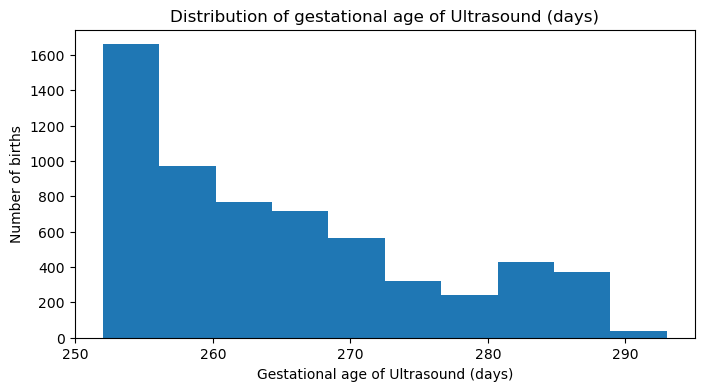

In [8]:
plt.figure(figsize=(8, 4))
plt.hist(merged["ultra_days"])      
plt.xlabel('Gestational age of Ultrasound (days)')
plt.ylabel('Number of births')
plt.title('Distribution of gestational age of Ultrasound (days)')

In [9]:
(merged['gestday'] == 999).sum()

618

In [10]:
merged['deliv_days'].isna().sum()

618

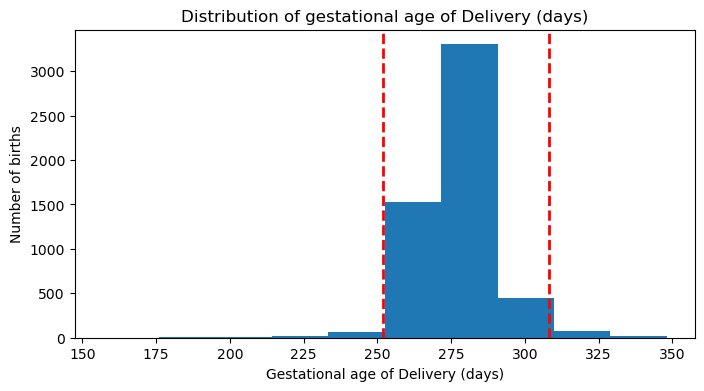

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(merged['deliv_days'])        # 7-day bins ≈ 1 week
plt.xlabel('Gestational age of Delivery (days)')
plt.ylabel('Number of births')
plt.title('Distribution of gestational age of Delivery (days)')
plt.axvline(252, color='red', linestyle='--', linewidth=2)
plt.axvline(308, color='red', linestyle='--', linewidth=2)

In [12]:
(merged['gestday'] < 252).sum()

83

In [13]:
(merged['gestday'] > 308).sum()

719

In [14]:
((merged['gestday'] > 252) & (merged['gestday'] < 308)).sum()

5260

In [15]:
merged['f_weight'].isna().sum()

167

In [16]:
merged['ga_diff_days'] = merged['deliv_days'] - merged['ultra_days']

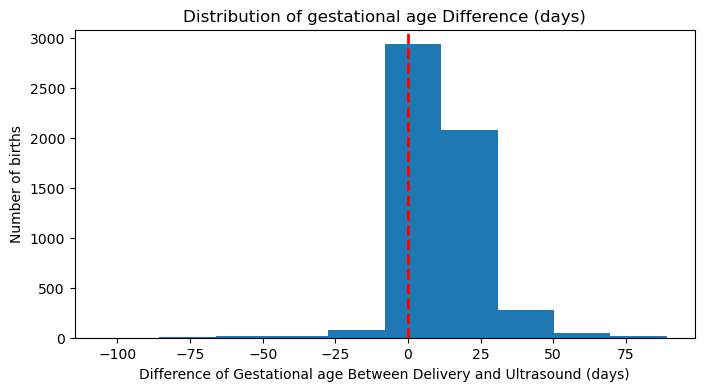

In [17]:
plt.figure(figsize=(8, 4))
plt.hist(merged['ga_diff_days'])  
plt.xlabel('Difference of Gestational age Between Delivery and Ultrasound (days)')
plt.ylabel('Number of births')
plt.title('Distribution of gestational age Difference (days)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)

In [18]:
(merged['ga_diff_days'] >= 0).sum()

5187

In [19]:
(merged['ga_diff_days'] < 0).sum()

274

In [20]:
outlier_mask = merged['ga_diff_days'] < 0
outliers = merged.loc[
    outlier_mask,
    ['MRN', 'f_weight', 'gestday',
     'deliv_days', 'ultra_days', 'ga_diff_days',
     'best', 'birth_wgt']
].copy()
outliers = outliers.sort_values('ga_diff_days', ascending=False)
print(outliers.shape)
outliers.head(20)

(274, 8)


,MRN,f_weight,gestday,deliv_days,ultra_days,ga_diff_days,best,birth_wgt
4439,E368930,3833.0,277,277.0,278,-1.0,39w 5d,3770
5231,E626279,NaN,251,251.0,252,-1.0,36w 0d,2440
1114,E1381418,2793.0,254,254.0,255,-1.0,36w 3d,3175
1724,E183435,3242.0,266,266.0,267,-1.0,38w 1d,2910
870,E1224944,3243.0,282,282.0,283,-1.0,40w 3d,3400
2572,E2413055,3849.0,282,282.0,283,-1.0,40w 3d,3750
751,E1166569,3653.0,251,251.0,252,-1.0,36w 0d,3820
3148,E2661186,2958.0,266,266.0,267,-1.0,38w 1d,3110
3170,E2668572,4253.0,276,276.0,277,-1.0,39w 4d,4010
3447,E289081,2841.0,261,261.0,262,-1.0,37w 3d,3005


In [21]:
outliers['ga_diff_days'].describe()

count    274.000000
mean     -13.795620
std       17.168691
min     -105.000000
25%      -16.750000
50%       -7.000000
75%       -4.000000
max       -1.000000
Name: ga_diff_days, dtype: float64

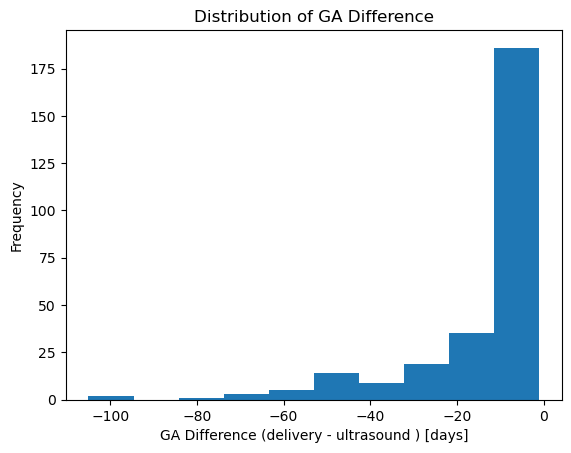

In [22]:
diffs = outliers['ga_diff_days'].dropna()
plt.figure()
plt.hist(diffs)
plt.xlabel('GA Difference (delivery - ultrasound ) [days]')
plt.ylabel('Frequency')
plt.title('Distribution of GA Difference')
plt.show()

In [23]:
# --- 0)  baseline ------------------------------------------------------------
df0 = merged.copy()
n0  = len(df0)
print(f"START: {n0:,} rows")

# --- 1)  GA < 44 wk (308 d) --------------------------------------------------
mask1 = (df0['deliv_days'] <= 308) & (df0['ultra_days'] <= 308)
df1   = df0.loc[mask1]
d1    = n0 - len(df1)
print(f"STEP 1  (GA < 44 wk):  dropped {d1:,} rows → {len(df1):,}")

# --- 2)  delivery ≥ ultrasound ----------------------------------------------
mask2 = df1['deliv_days'] >= df1['ultra_days']
df2   = df1.loc[mask2]
d2    = len(df1) - len(df2)
print(f"STEP 2  (deliv ≥ ultra): dropped {d2:,} rows → {len(df2):,}")

# --- 3)  drop NAs in key columns --------------------------------------------
cols_na = ['f_weight', 'deliv_days', 'ultra_days']
df3     = df2.dropna(subset=cols_na)
d3      = len(df2) - len(df3)

# Detailed NA counts for curiosity
na_counts = df2[cols_na].isna().sum()

print(f"STEP 3  (drop NAs):        dropped {d3:,} rows → {len(df3):,}")
print("          └─ broken down by column:")
for c, n in na_counts.items():
    print(f"             • missing {c:<11}: {n:,}")

# df3 is your final cleaned DataFrame


START: 6,079 rows
STEP 1  (GA < 44 wk):  dropped 719 rows → 5,360
STEP 2  (deliv ≥ ultra): dropped 274 rows → 5,086
STEP 3  (drop NAs):        dropped 141 rows → 4,945
          └─ broken down by column:
             • missing f_weight   : 141
             • missing deliv_days : 0
             • missing ultra_days : 0


In [24]:
merged = (
    merged
        .loc[(merged['deliv_days']   <= 308) & 
           (merged['ultra_days']   <= 308)]
        .loc[(merged['deliv_days'] >= merged['ultra_days'])]   # rule 1
      .dropna(subset=['f_weight', 'deliv_days'])             # rules 2 & 3
      .copy()
)
merged.shape

(4945, 212)

In [25]:
n_single = (merged['plurality'] == "1:Single").sum()
n_single
n_single_mrns = merged.loc[merged['plurality'] == "1:Single", 'MRN'].nunique()
n_single_mrns

4770

In [26]:
mask_twins = merged['plurality'] == "2:Twin"
n_twin_mrns = merged.loc[mask_twins, 'MRN'].nunique()
n_twin_mrns

89

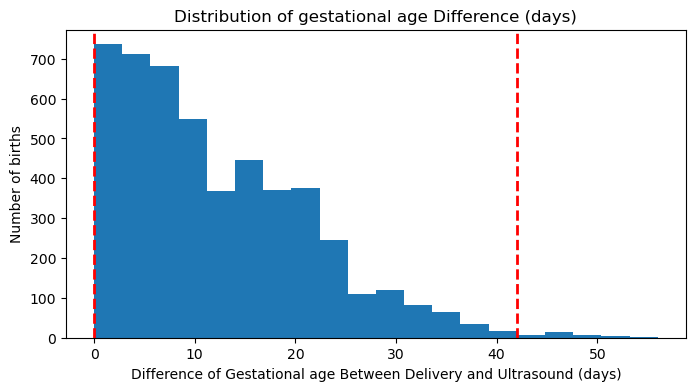

In [27]:
plt.figure(figsize=(8, 4))
plt.hist(merged['ga_diff_days'],bins=20)  
plt.xlabel('Difference of Gestational age Between Delivery and Ultrasound (days)')
plt.ylabel('Number of births')
plt.title('Distribution of gestational age Difference (days)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.axvline(42, color='red', linestyle='--', linewidth=2)

In [28]:
(merged['ga_diff_days'] > 42).sum()

32

In [29]:
merged['ga_diff_days'].max()  

56.0

In [30]:
merged = merged[merged["plurality"] == "1:Single"]
merged

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,Other Rare or Miscellaneous,Placenta & Cord Conditions,Poor Fetal Growth,Prenatal Care & Follow‑Up,Reproductive Technology & Multiples,Trauma & External Injury,indications,ultra_days,deliv_days,ga_diff_days
0,006520,2015-03-03,Highland,14607.0,1:Male,1:Single,single,3754,006520,1:Yes,...,0,0,0,0,0,0,"breech presentation suspected, not found",257,285.0,28.0
1,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1:Yes,...,0,0,0,0,0,0,bicornuate uterus; size greater than dates,252,282.0,30.0
2,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1:Yes,...,0,0,0,0,0,0,bleeding before 22 weeks; size greater than dates,265,266.0,1.0
3,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1:Yes,...,0,0,0,0,0,0,size less than dates,273,283.0,10.0
4,023246,2015-04-15,Highland,14624.0,1:Male,1:Single,single,4250,023246,0:No,...,0,1,0,0,0,0,post dates; 2 vessel umbilical cord; choroid p...,286,301.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,E996508,2023-01-05,Strong,14450.0,1:Male,1:Single,single,3160,E996508,1:Yes,...,0,0,1,0,0,0,medication use in pregnancy (single pregnancy)...,258,285.0,27.0
6074,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0:No,...,0,0,0,0,0,0,"hypertension, chronic, 3rd tri",265,270.0,5.0
6075,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1:Yes,...,0,0,0,0,0,0,"advanced maternal age, multigravida, 3rd tri; ...",262,266.0,4.0
6076,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1:Yes,...,0,0,0,0,0,0,"adult bmi 38.0-38.9; gestational diabetes, uns...",261,283.0,22.0


## Brenner

In [31]:
merged['predicted_bw_brenner'] = merged.apply(compute_predicted_bw_interp, axis=1,args=('brenner',)).astype("Int64")

In [32]:
print( merged['predicted_bw_brenner'].describe() )

count         4770.0
mean     3486.227254
std       513.054169
min           1719.0
25%          3155.25
50%           3477.0
75%          3818.75
max           5915.0
Name: predicted_bw_brenner, dtype: Float64


In [33]:
merged["error_brenner"] = (merged['predicted_bw_brenner'] - merged['birth_wgt'])
merged["error_brenner"].describe()

count        4770.0
mean     109.659958
std      275.708066
min         -1339.0
25%           -65.0
50%           113.5
75%           287.0
max          1288.0
Name: error_brenner, dtype: Float64

In [34]:
merged['abs_error_brenner'] = (merged['predicted_bw_brenner'] - merged['birth_wgt']).abs()
merged['abs_error_brenner'].describe()

count        4770.0
mean     233.466247
std      183.097917
min             0.0
25%            91.0
50%           193.0
75%           333.0
max          1339.0
Name: abs_error_brenner, dtype: Float64

In [35]:
merged['pct_error_brenner'] = (merged['predicted_bw_brenner'] - merged['birth_wgt']) / merged['birth_wgt'] * 100
merged["pct_error_brenner"].describe()

count       4770.0
mean      3.662439
std       8.298636
min     -25.576208
25%      -1.910576
50%       3.418406
75%       8.870586
max      44.490501
Name: pct_error_brenner, dtype: Float64

In [36]:
merged['abs_pct_error_brenner']= ((merged['predicted_bw_brenner'] - merged['birth_wgt']) / merged['birth_wgt'] * 100).abs()
merged['abs_pct_error_brenner'].describe()

count       4770.0
mean       7.06701
std       5.685994
min            0.0
25%       2.682826
50%       5.773596
75%      10.148863
max      44.490501
Name: abs_pct_error_brenner, dtype: Float64

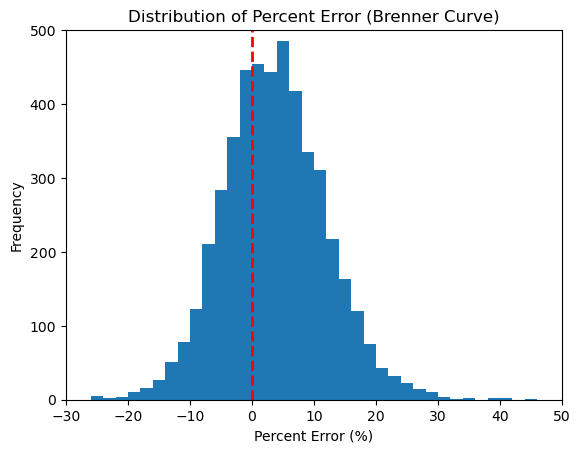

In [37]:
errors = merged['pct_error_brenner'].dropna()
bins = np.arange(-30, 52, 2)
xlim = (-30, 50)
ylim = (0, 500)
# plot histogram
plt.figure()
plt.hist(errors, bins=bins)
plt.xlabel('Percent Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percent Error (Brenner Curve)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlim(xlim)                       # ← lock x-scale
plt.ylim(ylim)                       # ← lock y-scale
plt.show()

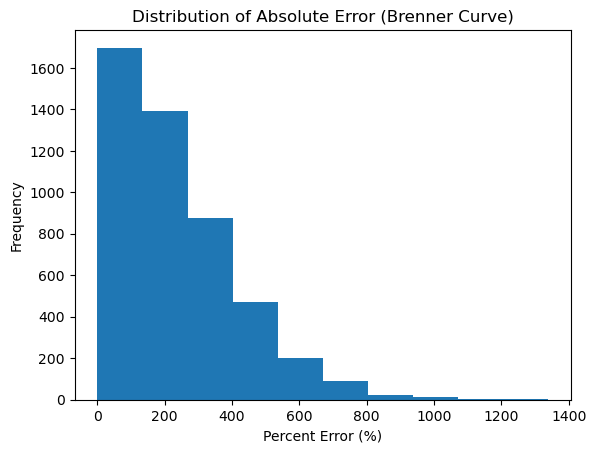

In [38]:
errors = merged['abs_error_brenner'].dropna()
# plot histogram
plt.figure()
plt.hist(errors)
plt.xlabel('Percent Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Error (Brenner Curve)')
plt.show()

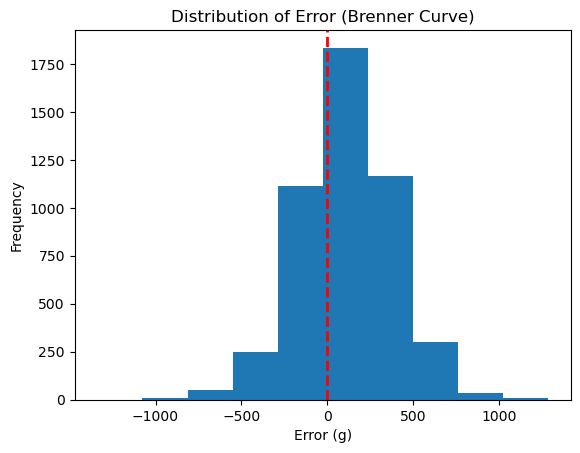

In [39]:
errors = merged['error_brenner'].dropna()
# plot histogram
plt.figure()
plt.hist(errors)
plt.xlabel('Error (g)')
plt.ylabel('Frequency')
plt.title('Distribution of Error (Brenner Curve)')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.show()

In [40]:
from scipy import stats
y = merged["abs_error_brenner"].dropna()
# 1. With pandas (Fisher-Pearson sample skewness, bias-corrected)
skew_val = y.skew()          # equivalent to y.skew(skipna=True)
print(f"Skewness (pandas) = {skew_val:0.3f}")

# 2. With SciPy (you can choose bias-corrected or not)
skew_val_scipy = stats.skew(y, bias=False)   # bias=False matches pandas
print(f"Skewness (SciPy)  = {skew_val_scipy:0.3f}")


Skewness (pandas) = 1.226
Skewness (SciPy)  = 1.226


/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


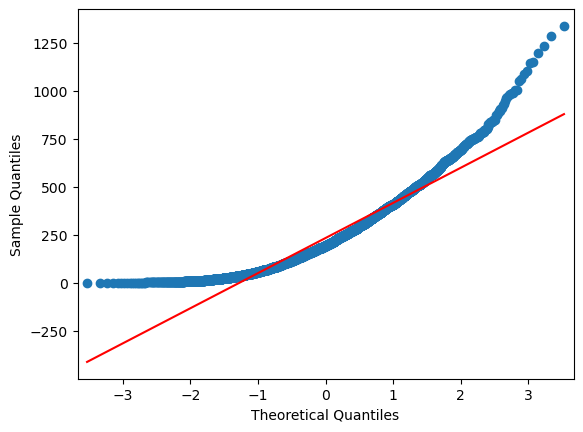

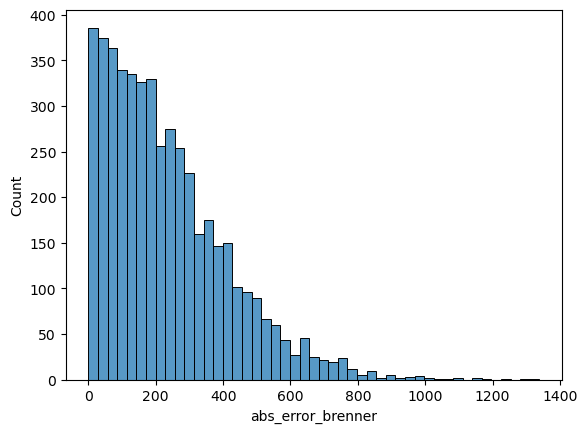

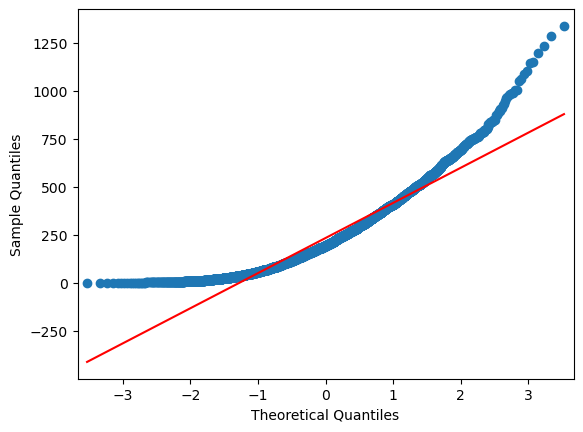

In [41]:
sns.histplot(merged["abs_error_brenner"])
sm.qqplot(merged["abs_error_brenner"], line="s")

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


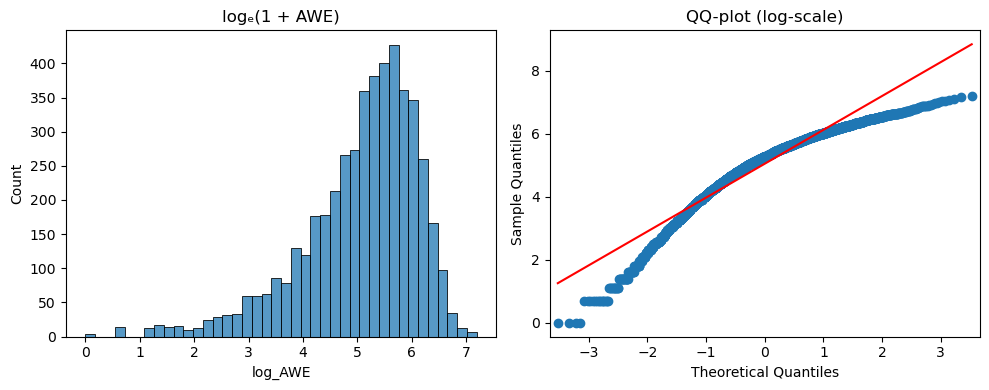

In [42]:
merged["log_AWE"] = np.log1p(merged["abs_error_brenner"])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(merged["log_AWE"].dropna(), bins=40, ax=ax[0])
ax[0].set_title("logₑ(1 + AWE)")

sm.qqplot(merged["log_AWE"].dropna(), line="s", ax=ax[1])
ax[1].set_title("QQ-plot (log-scale)")
plt.tight_layout()

## Data Cleaning 

In [43]:
n_total = len(merged)
summary = (
    pd.DataFrame({
        'dtype'       : merged.dtypes,
        'non_null'    : merged.notna().sum(),
        'missing'     : merged.isna().sum(),
        'unique'      : merged.nunique(dropna=True)
    })
    .assign(miss_pct=lambda df_: (df_['missing'] / n_total * 100).round(2))
    .reset_index()
    .rename(columns={'index':'variable'})
)


#summary.to_excel('variable_summary.xlsx', index=False)
summary.head(15)

,variable,dtype,non_null,missing,unique,miss_pct
0,MRN,object,4770,0,4770,0.00
1,Date___Time,object,4770,0,1621,0.00
2,hospcode,object,4770,0,2,0.00
3,reszip5,float64,4764,6,248,0.13
4,sex_of_inf,object,4770,0,2,0.00
5,plurality,object,4770,0,1,0.00
6,birth_orde,object,4770,0,1,0.00
7,birth_wgt,int64,4770,0,1161,0.00
8,mom_medrec,object,4770,0,4770,0.00
9,mom_whi,object,4770,0,2,0.00


In [44]:
merged

,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,indications,ultra_days,deliv_days,ga_diff_days,predicted_bw_brenner,error_brenner,abs_error_brenner,pct_error_brenner,abs_pct_error_brenner,log_AWE
0,006520,2015-03-03,Highland,14607.0,1:Male,1:Single,single,3754,006520,1:Yes,...,"breech presentation suspected, not found",257,285.0,28.0,3590,-164,164,-4.368673,4.368673,5.105945
1,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1:Yes,...,bicornuate uterus; size greater than dates,252,282.0,30.0,3253,-166,166,-4.855221,4.855221,5.117994
2,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1:Yes,...,bleeding before 22 weeks; size greater than dates,265,266.0,1.0,3724,186,186,5.257207,5.257207,5.231109
3,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1:Yes,...,size less than dates,273,283.0,10.0,2968,39,39,1.331512,1.331512,3.688879
4,023246,2015-04-15,Highland,14624.0,1:Male,1:Single,single,4250,023246,0:No,...,post dates; 2 vessel umbilical cord; choroid p...,286,301.0,15.0,4428,178,178,4.188235,4.188235,5.187386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,E996508,2023-01-05,Strong,14450.0,1:Male,1:Single,single,3160,E996508,1:Yes,...,medication use in pregnancy (single pregnancy)...,258,285.0,27.0,2902,-258,258,-8.164557,8.164557,5.556828
6074,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0:No,...,"hypertension, chronic, 3rd tri",265,270.0,5.0,3197,87,87,2.797428,2.797428,4.477337
6075,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1:Yes,...,"advanced maternal age, multigravida, 3rd tri; ...",262,266.0,4.0,3502,262,262,8.08642,8.08642,5.572154
6076,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1:Yes,...,"adult bmi 38.0-38.9; gestational diabetes, uns...",261,283.0,22.0,3959,-1,1,-0.025253,0.025253,0.693147


In [45]:
unique_vals = merged['mhis_no'].dropna().unique()
print(unique_vals)


['Not Hispanic' 'Hispanic']


In [46]:
unique_vals = merged['pres_del'].dropna().unique()
print(unique_vals)

['1:Cephalic' '2:Breech' '3:Other']


In [47]:
pres_dummies = pd.get_dummies(merged["pres_del"],
                              drop_first=True,
                              dtype= int)
merged = pd.concat([merged, pres_dummies], axis=1)
pres=["2:Breech", "3:Other"]
merged["2:Breech"]

0       0
1       0
2       0
3       0
4       0
       ..
6072    0
6074    0
6075    0
6076    0
6078    0
Name: 2:Breech, Length: 4770, dtype: int64

In [48]:
len(merged)

4770

In [49]:
unique_vals = merged['calc_trimester'].dropna().unique()
print(unique_vals)

['1st trimester' 'Missing' '2nd trimester' '3rd trimester']


In [50]:
counts = (merged["calc_trimester"]
          .value_counts()
          .rename_axis("calc_trimester")
          .reset_index(name="count"))

print(counts)

  calc_trimester  count
0  1st trimester   3651
1  2nd trimester    802
2  3rd trimester    163
3        Missing    152


In [51]:
merged["1_trimester"] = (merged["calc_trimester"] == "1st trimester").astype(int)
merged["2_trimester"] = (merged["calc_trimester"] == "2nd trimester").astype(int)
merged["3_trimester"] = (merged["calc_trimester"] == "3rd trimester").astype(int)
trim=["2_trimester", "3_trimester"]

In [52]:
unique_vals = merged['depression'].dropna().unique()
print(unique_vals)

['1:Not depressed at all' 'missing' '2:A little depressed'
 '3:Moderately depressed' '4:Very Depressed'
 '5:Very depressed and had to be helped']


In [53]:
counts = (merged["depression"]
          .value_counts()
          .reset_index(name="count"))

print(counts)

                              depression  count
0                 1:Not depressed at all   2446
1                                missing   1117
2                   2:A little depressed    852
3                 3:Moderately depressed    242
4  5:Very depressed and had to be helped     68
5                       4:Very Depressed     45


In [54]:
merged["male"] = (merged["sex_of_inf"] == "1:Male").astype(int)
merged["not_hispanic"] = (merged["mhis_no"] == "Not Hispanic").astype(int)

In [55]:
binary_map = {"1:Yes": 1, "0:No": 0}
race = ["mom_whi", "mom_bla", "mom_si","mom_chi", "mom_fil", "mom_jap","mom_kor","mom_vie","mom_nha",
        "mom_gua","mom_sam","mom_aina","mom_oas","mom_opi","mom_oth"]
merged[race] = merged[race].replace(binary_map).astype("Int8")

race_groups = {
    "AIAN":  ["mom_aina"],                                           # American Indian/Alaska Native
    "Asian": ["mom_si", "mom_chi", "mom_fil", "mom_jap",
              "mom_kor", "mom_vie", "mom_oas"],
    "Black": ["mom_bla"],
    "PI_NH": ["mom_nha", "mom_gua", "mom_sam", "mom_opi"],           # Pacific Islander / Native Hawaiian
    "Other": ["mom_oth"],
    "White": ["mom_whi"],
}

for grp, cols in race_groups.items():
    merged[grp] = merged[cols].any(axis=1).astype("Int8") 
race = ["AIAN","Asian","Black","PI_NH","Other"]

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/3651328839.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged[race] = merged[race].replace(binary_map).astype("Int8")


In [56]:
hispanic = ["mhis_me","mhis_pr","mhis_cu","mhis_ot"]
merged[hispanic] = merged[hispanic].replace(binary_map).astype("Int8")

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/1014566273.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged[hispanic] = merged[hispanic].replace(binary_map).astype("Int8")


In [57]:
merged["hispanic"]=merged["mhis_no"].replace({'Not Hispanic': 0,'Hispanic': 1,'9:Unknown':pd.NA}).astype('Int8')

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/1851232837.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["hispanic"]=merged["mhis_no"].replace({'Not Hispanic': 0,'Hispanic': 1,'9:Unknown':pd.NA}).astype('Int8')


In [58]:
merged['none_medri'] = merged['none_medri'].replace({'0:Med risk factors present': 1,'1:No med risk factors present': 0}).astype('Int8')

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/2375446669.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['none_medri'] = merged['none_medri'].replace({'0:Med risk factors present': 1,'1:No med risk factors present': 0}).astype('Int8')


In [59]:
pregancy_risk_factors = ["other_ill","abrupt","diabetes_m",'diabetes_g','hyper_chro',"hyper_preg",
                         "pre_term_m","poor_preg","vag_","prelab_ref",
                        "unk_risk"]
merged[pregancy_risk_factors] = merged[pregancy_risk_factors].replace(binary_map).astype("Int8")

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/329518717.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged[pregancy_risk_factors] = merged[pregancy_risk_factors].replace(binary_map).astype("Int8")


In [60]:
unique_vals = merged['prev_cs'].dropna().unique()
print(unique_vals)

['0:No' '1:Yes' '9:Unknown']


In [61]:
merged["prev_cs"]=merged["prev_cs"].replace({'0:No': 0,'1:Yes': 1,'9:Unknown':pd.NA}).astype('Int8')

In [62]:
unique_vals = merged['none'].dropna().unique()
print(unique_vals)

['0:No' '1:Yes']


In [63]:
infection = ["infec_gc","syph_medri",'infec_hsv','chlamyd',"hepb","hepc","tb_medrisk","rubella_me",
             "bac_vag","unk_inf"]
merged[infection] = merged[infection].replace(binary_map).astype("Int8")

merged["none"]=merged["none"].replace({'0:No': 0,'1:Yes': 1}).astype('Int8')

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/1657578960.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged[infection] = merged[infection].replace(binary_map).astype("Int8")
/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/1657578960.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["none"]=merged["none"].replace({'0:No': 0,'1:Yes': 1}).astype('Int8')


In [64]:
unique_vals = merged['none_obpro'].dropna().unique()
print(unique_vals)

['1:Yes' '0:No']


In [65]:
unique_vals = merged['proc_ecv'].dropna().unique()
print(unique_vals)

['0:No' '1:Yes' '2']


In [66]:
obstetric_procedures = ["none_obpro","proc_cer","toco_obpro",'proc_tocol']
merged[obstetric_procedures] = merged[obstetric_procedures].replace(binary_map).astype("Int8")

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/3684541276.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged[obstetric_procedures] = merged[obstetric_procedures].replace(binary_map).astype("Int8")


In [67]:
unique_vals = merged['none_congm'].dropna().unique()
print(unique_vals)

['1:No Congenitial anomaly present' '0:Congenitial anomaly present']


In [68]:
merged['none_congm'] = merged['none_congm'].replace({'0:Congenitial anomaly present': 1,'1:No Congenitial anomaly present': 0}).astype('Int8')

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/3673534837.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['none_congm'] = merged['none_congm'].replace({'0:Congenitial anomaly present': 1,'1:No Congenitial anomaly present': 0}).astype('Int8')


In [69]:
congenital_malformation = ["unk_at","anenceph_c","m_spina",'c_heart','diaphram_h',"omphalo","gastros",
                           "limb_reduc","cleft_lipx","cleft","down_sy","down_ka","down_kp","chrom_di",
                          "chro_kc","chro_kp","hypospa"]
merged[congenital_malformation] = merged[congenital_malformation].replace(binary_map).astype("Int8")

/var/folders/nw/3jwfxsxs5hjf1kw6d5bq2bnw0000gn/T/ipykernel_15919/684114403.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged[congenital_malformation] = merged[congenital_malformation].replace(binary_map).astype("Int8")


In [70]:
unique_vals = merged['tobacco_yn'].dropna().unique()
print(unique_vals)

['0:No' '1:Yes' '9:Unknown']


In [71]:
merged["tobacco_yn"]=merged["tobacco_yn"].replace({'0:No': 0,'1:Yes': 1,'9:Unknown':pd.NA}).astype('Int8')

In [72]:
smoke = ["tobacco_yn","smo_pri","smo_1st","smo_2nd","smo_3rd"]
merged["any_smoke"] = (merged[smoke].gt(0).any(axis=1)).astype("int8")

In [73]:
unique_vals = merged['alcohol_ot'].dropna().unique()
print(unique_vals)

['0:No' '1:Yes' '9:Unknown']


In [74]:
merged["alcohol_ot"]=merged["alcohol_ot"].replace({'0:No': 0,'1:Yes': 1,'9:Unknown':pd.NA}).astype('Int8')

In [75]:
unique_vals = merged['idrug_y'].dropna().unique()
print(unique_vals)

['0:No' '1:Yes' '9:Unknown']


In [76]:
merged["idrug_y"]=merged["idrug_y"].replace({'0:No': 0,'1:Yes': 1,'9:Unknown':pd.NA}).astype('Int8')

In [77]:
unique_vals = merged['pre_yes'].dropna().unique()
print(unique_vals)

['1:Yes']


In [78]:
merged['num_cs'].value_counts(dropna=False).sort_index()

num_cs
0     3971
1      618
2      126
3       37
4        7
99      11
Name: count, dtype: int64

In [79]:
merged['num_cs'] = merged['num_cs'].replace(99, np.nan)

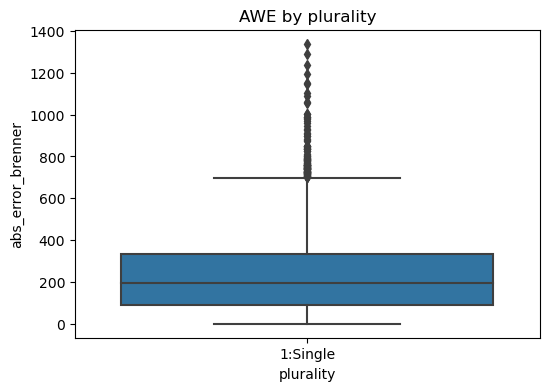

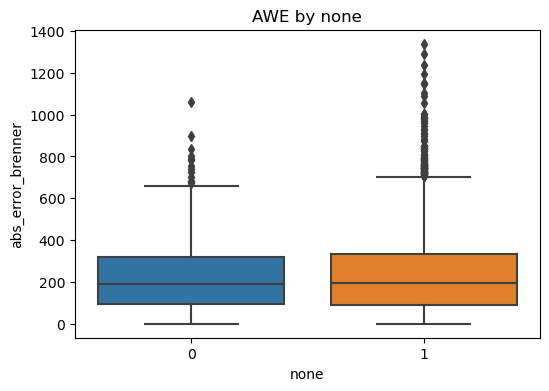

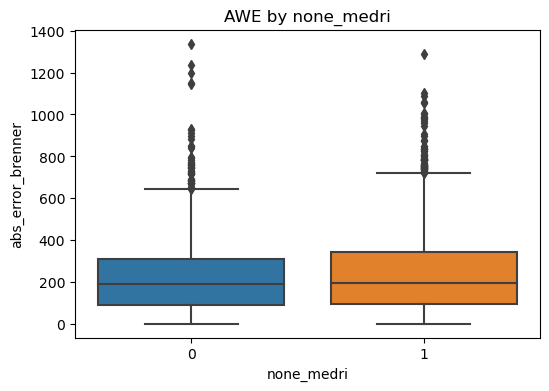

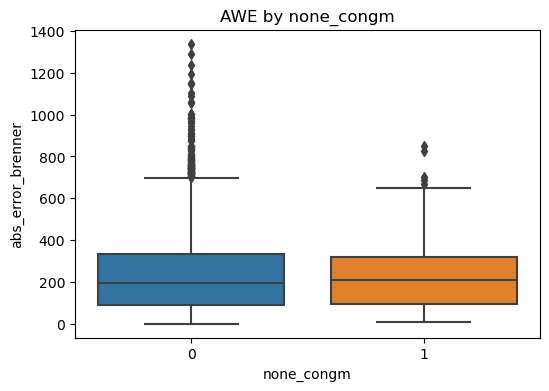

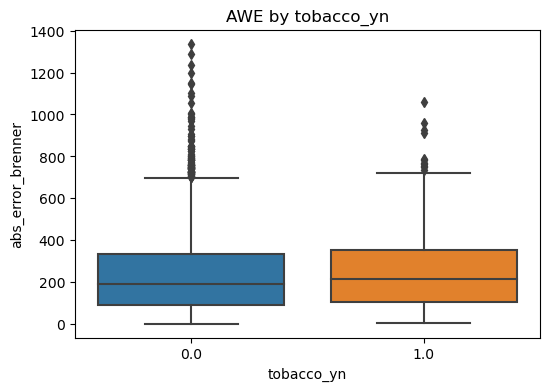

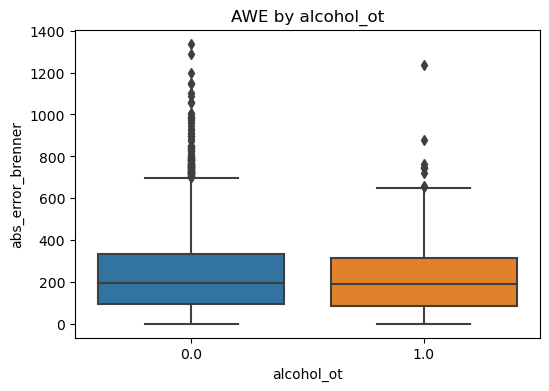

In [80]:
cat_cols = ["plurality", "none", "none_medri","none_congm","tobacco_yn","alcohol_ot"]   # ✏️  update as needed
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, y="abs_error_brenner", data=merged, showfliers=True)
    plt.yscale("linear"); plt.title(f"AWE by {col}")
    plt.show()

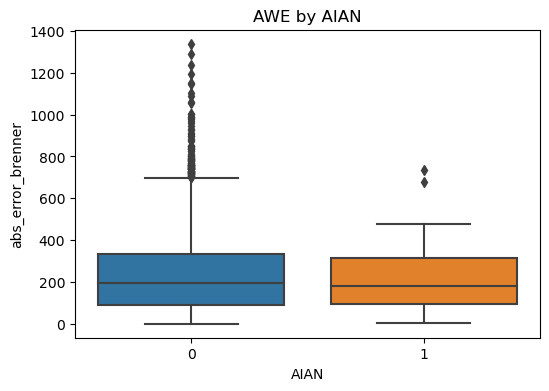

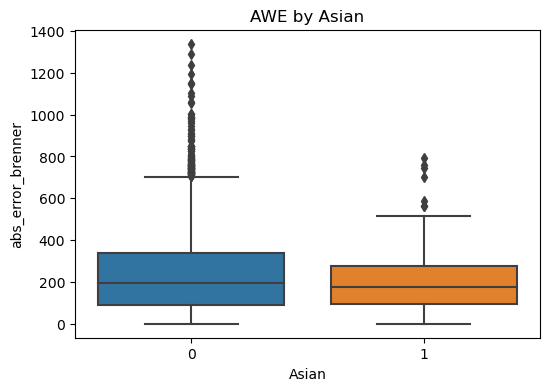

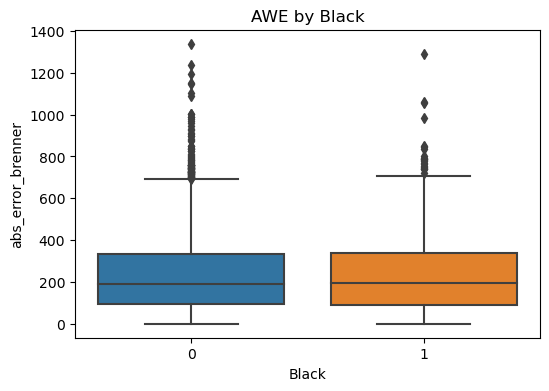

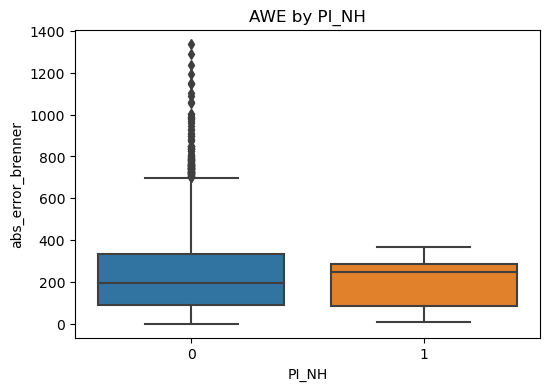

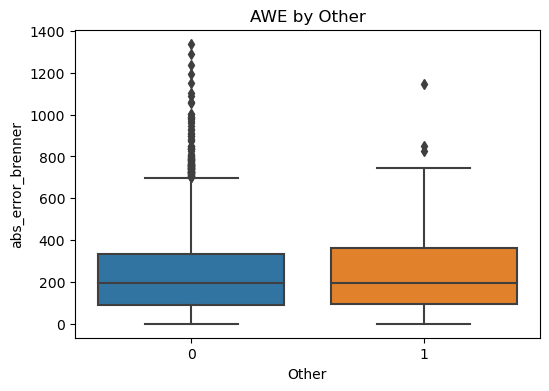

In [81]:
for col in race:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, y="abs_error_brenner", data=merged, showfliers=True)
    plt.yscale("linear"); plt.title(f"AWE by {col}")
    plt.show()

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


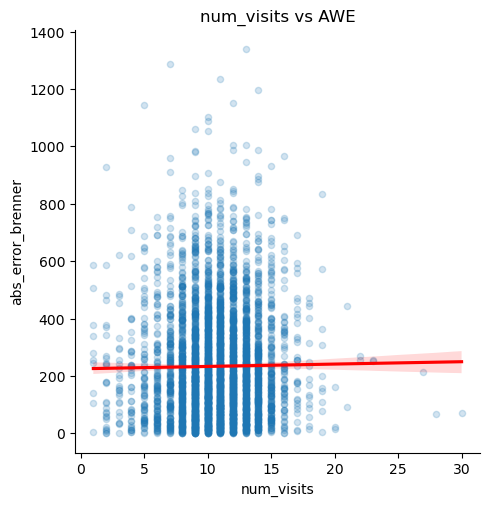

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


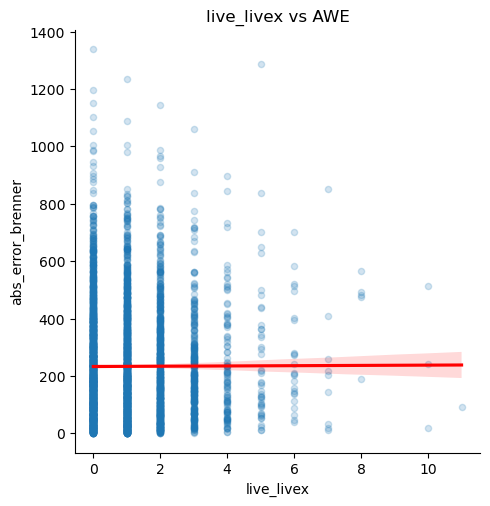

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


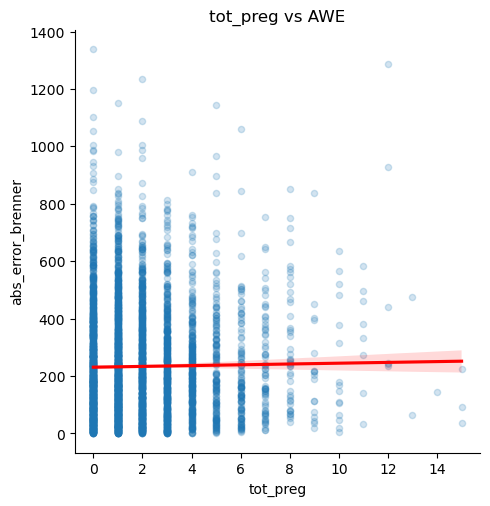

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


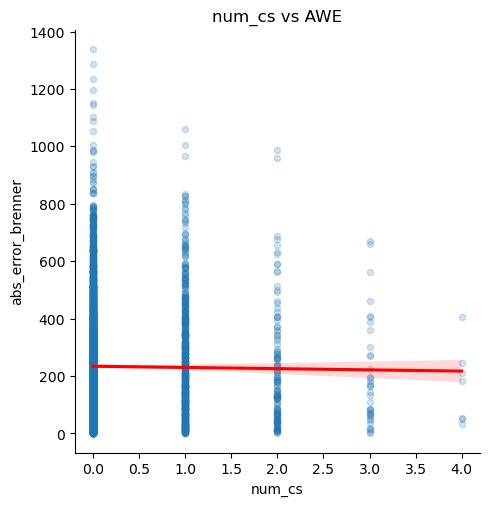

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


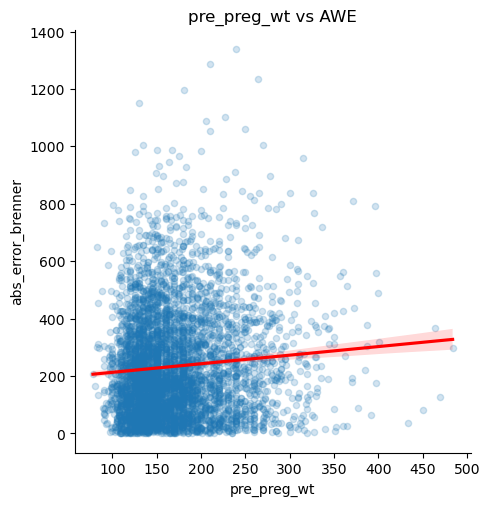

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


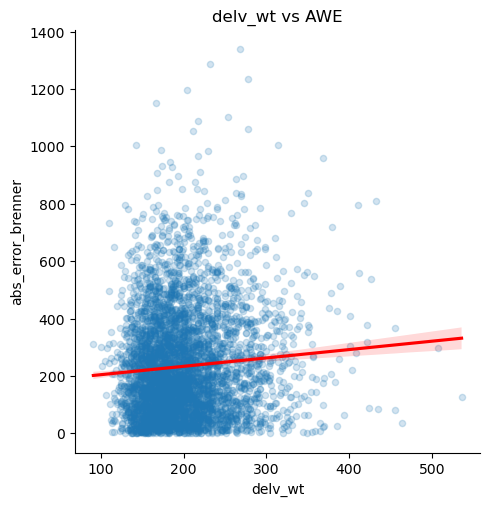

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


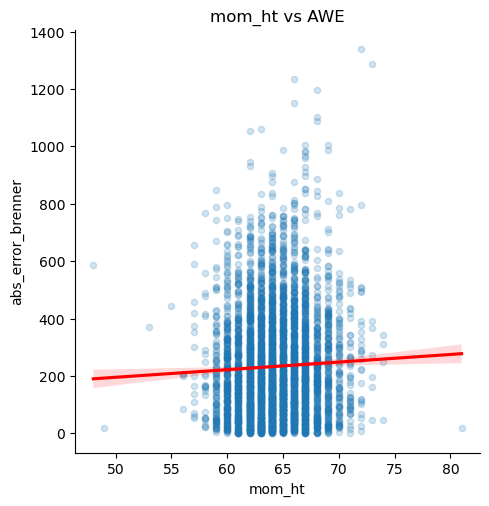

/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/xiongsimeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


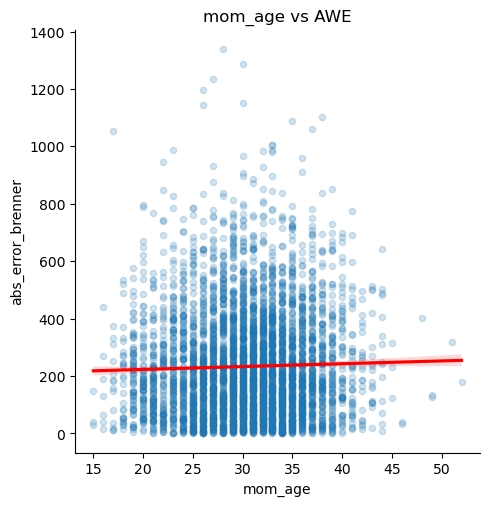

In [82]:
num_cols = ["num_visits", "live_livex", "tot_preg","num_cs","pre_preg_wt","delv_wt","mom_ht","mom_age"]   # ✏️
for col in num_cols:
    sns.lmplot(x=col, y="abs_error_brenner", data=merged,
               scatter_kws={'alpha':.20, 's':20},
               line_kws={'color':'red'})
    plt.yscale("linear"); plt.title(f"{col} vs AWE")
    plt.show()


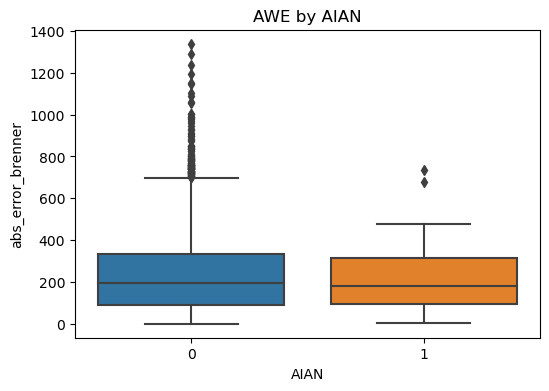

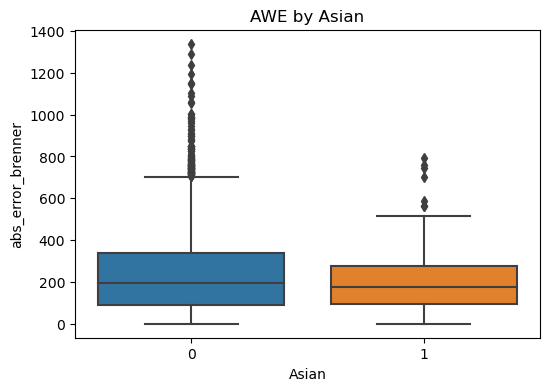

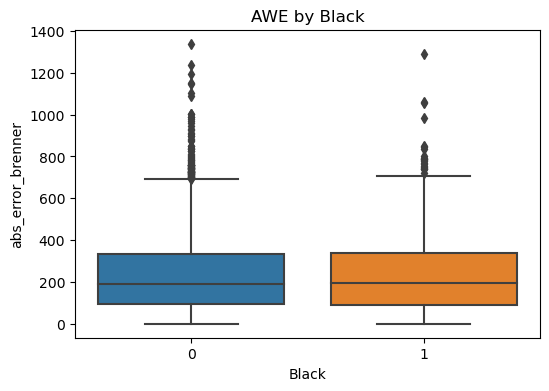

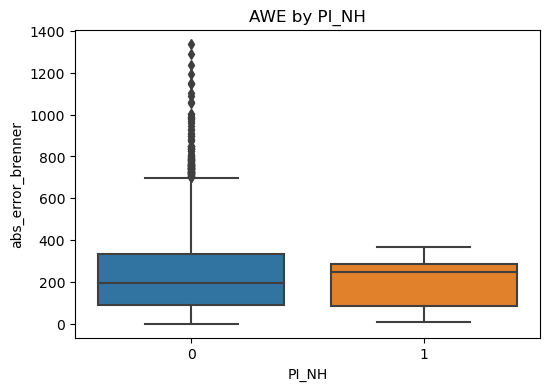

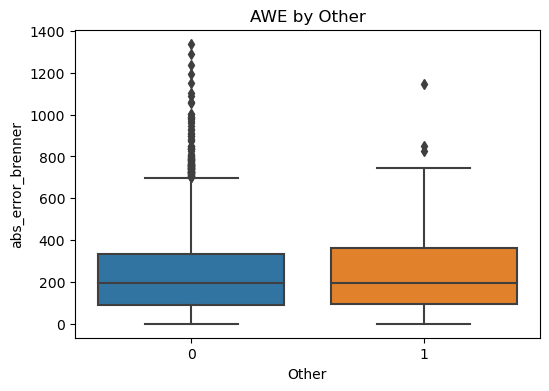

In [83]:
for col in race:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, y="abs_error_brenner", data=merged, showfliers=True)
    plt.yscale("linear"); plt.title(f"AWE by {col}")
    plt.show()

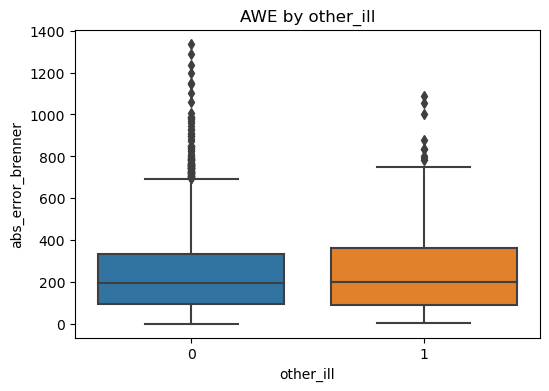

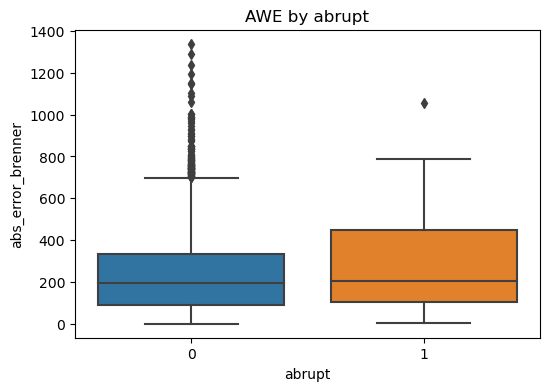

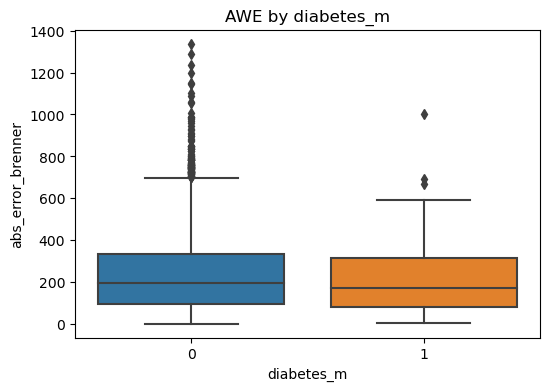

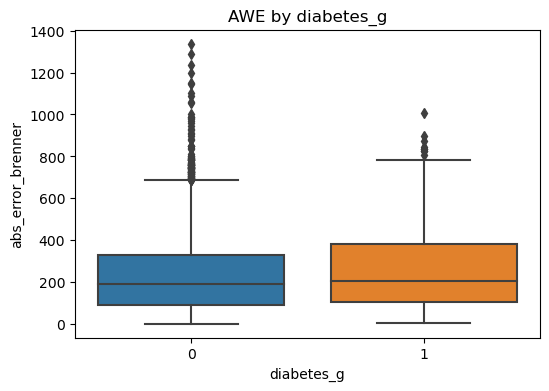

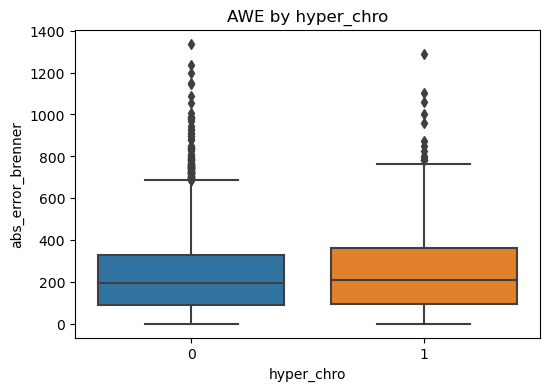

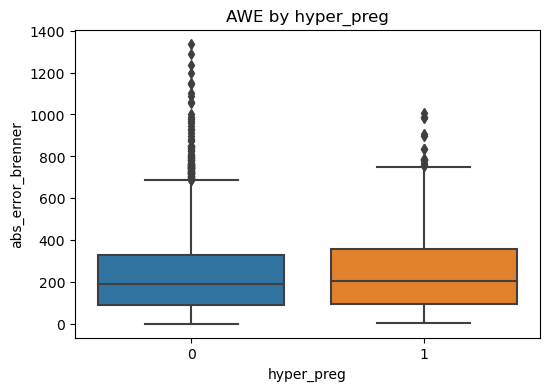

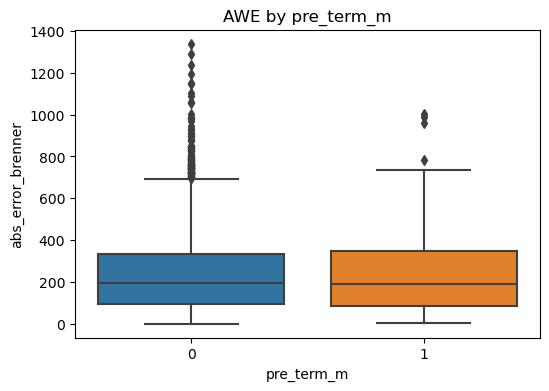

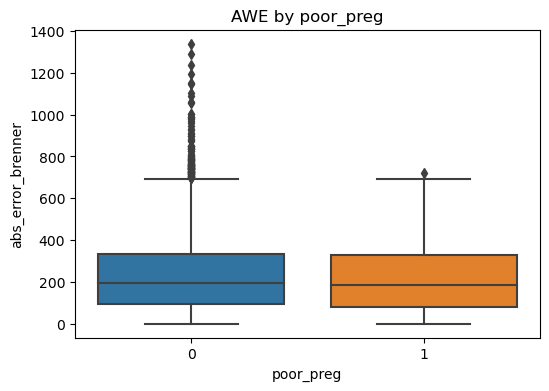

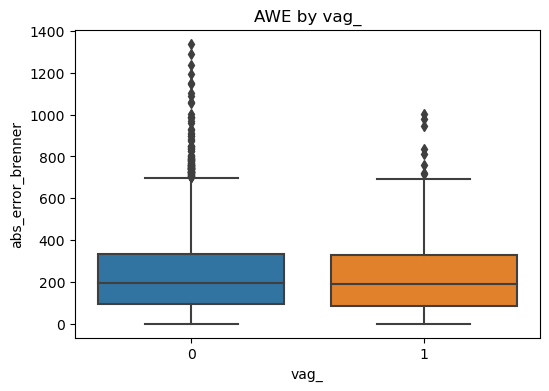

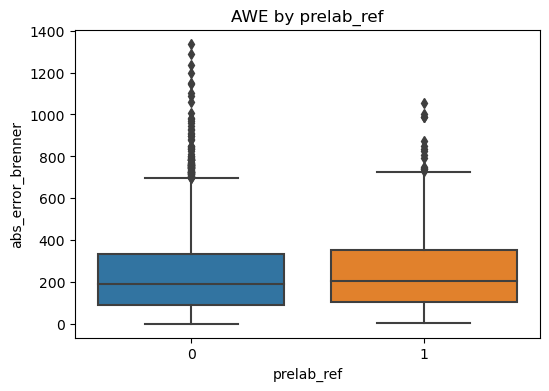

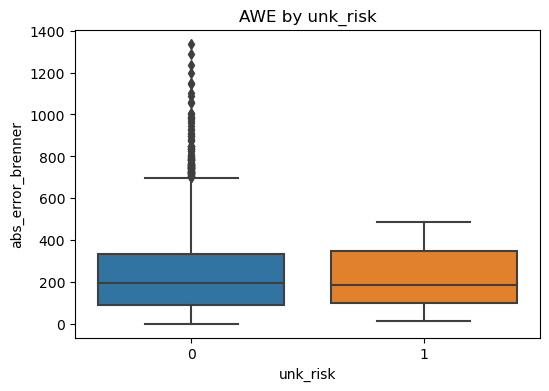

In [84]:
for col in pregancy_risk_factors:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, y="abs_error_brenner", data=merged, showfliers=True)
    plt.yscale("linear"); plt.title(f"AWE by {col}")
    plt.show()

## LASSO

In [94]:
zero_cnt, zero_pct = (y == 0).sum(), (y == 0).mean() * 100
print(f"{zero_cnt} zeros  ({zero_pct:.2f} % of the sample)")
merged = merged[merged["abs_error_brenner"]!=0]
merged

4 zeros  (0.08 % of the sample)


,MRN,Date___Time,hospcode,reszip5,sex_of_inf,plurality,birth_orde,birth_wgt,mom_medrec,mom_whi,...,male,not_hispanic,AIAN,Asian,Black,PI_NH,Other,White,hispanic,any_smoke
0,006520,2015-03-03,Highland,14607.0,1:Male,1:Single,single,3754,006520,1,...,1,1,0,0,0,0,0,1,0,0
1,008177,2014-01-31,Highland,14620.0,2:Female,1:Single,single,3419,008177,1,...,0,1,0,0,0,0,0,1,0,0
2,018533,2014-06-03,Highland,14618.0,1:Male,1:Single,single,3538,018533,1,...,1,1,0,0,0,0,0,1,0,0
3,020567,2015-02-26,Highland,14586.0,2:Female,1:Single,single,2929,020567,1,...,0,1,0,0,0,0,0,1,0,0
4,023246,2015-04-15,Highland,14624.0,1:Male,1:Single,single,4250,023246,0,...,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072,E996508,2023-01-05,Strong,14450.0,1:Male,1:Single,single,3160,E996508,1,...,1,1,0,0,0,0,0,1,0,0
6074,E996890,2023-05-19,Strong,14623.0,2:Female,1:Single,single,3110,E996890,0,...,0,1,0,0,1,0,0,0,0,0
6075,E996991,2021-11-03,Strong,14534.0,2:Female,1:Single,single,3240,E996991,1,...,0,1,0,0,0,0,0,1,0,0
6076,E998249,2020-04-22,Strong,14428.0,2:Female,1:Single,single,3960,E998249,1,...,0,1,0,0,0,0,0,1,0,1


In [ ]:
indications = [
    'Advanced Maternal Age', 
    'Amniotic Fluid Abnormalities', 
    'Autoimmune & Genetic Risk Factors', 
    'Bariatric Surgery', 
    'Bleeding, Pain & Hemorrhage', 
    'Cardiovascular Conditions', 
    'Dating & Gestational Age Assessments', 
    'Excessive Fetal Growth', 
    'Fetal Anomalies & Abnormal Screening Findings', 
    'Fetal Demise / Stillbirth', 
    'Fetal Position', 
    'Fetal Well‑Being Assessment', 
    'Growth & Size Discrepancies', 
    'Hematologic & Anemia', 
    'Infection & Inflammation', 
    'Lifestyle & Substance & Medication', 
    'Maternal Weight Gain - Excessive', 
    'Maternal Weight Gain - Insufficient', 
    'Mental Health Conditions', 
    'Metabolic & Endocrine Disorders', 
    'Obesity', 
    'Obstetric History & Uterine/Cervical', 
    'Other Maternal Health Conditions', 
    'Other Rare or Miscellaneous', 
    'Placenta & Cord Conditions', 
    'Poor Fetal Growth', 
    'Prenatal Care & Follow‑Up', 
    'Reproductive Technology & Multiples', 
    'Trauma & External Injury'
]

In [95]:
base_cols = ["male","hispanic","num_cs","none_congm","num_visits","live_livex","tot_preg",
              "any_smoke", "idrug_y", "num_drink", 
             "pre_preg_wt", "mom_ht",
    "mom_age"
]

feat_cols = base_cols + race + pregancy_risk_factors+trim


In [96]:
# --- 1.  which columns matter?  -----------------
y_col      = "abs_error_brenner"          # your outcome
cols_check = feat_cols + [y_col]          # all X + Y in the current model

# --- 2.  build a compact frame with just those columns -------------
df_all = merged[cols_check]

# --- 3.  drop rows that have a NA in *any* of these columns --------
df_clean = df_all.dropna()                # default axis=0 drops rows

# --- 4.  report ----------------------------------------------------
n_orig   = len(df_all)
n_clean  = len(df_clean)
n_lost   = n_orig - n_clean
print(f"Original rows : {n_orig:,}")
print(f"Rows after dropna : {n_clean:,}")
print(f"Rows removed    : {n_lost:,}  ({n_lost/n_orig:.1%} lost)")

# (Optional) see which columns drive most of the missingness
missing_by_col = df_all.isna().mean().sort_values(ascending=False)
display(missing_by_col)  # top 15 columns with NAs


Original rows : 4,766
Rows after dropna : 4,374
Rows removed    : 392  (8.2% lost)


pre_preg_wt          0.042593
num_visits           0.031893
num_drink            0.011960
live_livex           0.004196
tot_preg             0.003567
mom_ht               0.002728
num_cs               0.002308
idrug_y              0.001259
vag_                 0.000000
hyper_chro           0.000000
hyper_preg           0.000000
pre_term_m           0.000000
poor_preg            0.000000
male                 0.000000
prelab_ref           0.000000
unk_risk             0.000000
diabetes_m           0.000000
2_trimester          0.000000
3_trimester          0.000000
diabetes_g           0.000000
PI_NH                0.000000
abrupt               0.000000
other_ill            0.000000
Other                0.000000
hispanic             0.000000
Black                0.000000
Asian                0.000000
AIAN                 0.000000
mom_age              0.000000
any_smoke            0.000000
none_congm           0.000000
abs_error_brenner    0.000000
dtype: float64

In [97]:
X = merged[feat_cols].copy()
y = merged["abs_error_brenner"]

# Missing Value 
num_cols = ["pre_preg_wt", "mom_ht", "mom_age","num_cs","num_visits","live_livex","tot_preg"]
bin_cols = list(set(feat_cols) - set(num_cols))

X[num_cols] = X[num_cols].fillna(X[num_cols].median())  # 数值列 -> 中位数
X[bin_cols] = X[bin_cols].fillna(0)                     # 二元列 -> 0


In [ ]:

lasso = ElasticNetCV(
    l1_ratio  = 1.0,                   
    alphas    = np.logspace(-4, 1, 50),    # λ 搜索范围
    cv        =5,
    n_jobs    = -1,
    max_iter  = 10000,
    random_state = 42
).fit(X, y)

print(f"Best λ = {lasso.alpha_:.4f}")

y_pred = lasso.predict(X)

print("In-sample R²  :", round(r2_score(y, y_pred), 3))
print("In-sample MAE :", round(mean_absolute_error(y, y_pred), 1))


kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_fixed = ElasticNet(
    alpha      = lasso.alpha_,
    l1_ratio   = 1.0,
    max_iter   = 10000,
    random_state = 42
)

y_cv_pred = cross_val_predict(lasso_fixed, X, y, cv=kf, n_jobs=-1)
print("CV-R²        :", round(r2_score(y, y_cv_pred), 3))
print("CV-MAE (g)   :", round(mean_absolute_error(y, y_cv_pred), 1))


# 5️⃣ 非零系数
coef     = pd.Series(lasso.coef_, index=feat_cols)
coef_nz  = coef[coef != 0].sort_values(key=np.abs, ascending=False)

print(f"\nNon-zero coefficients  {coef_nz.size} / {coef.size} total")
display(coef_nz.to_frame("β"))

In [ ]:
selected = X.columns[lasso.coef_ != 0].tolist()
len(selected)

In [ ]:
X_sel = merged[selected].copy()
X_sel = X_sel.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
X_const = sm.add_constant(X_sel)
y = merged["abs_error_brenner"].astype(float)

ols  = sm.OLS(y, X_const).fit()
rob  = ols.get_robustcov_results(cov_type='HC3')   # 关键：稳健SE

print(rob.summary())

In [ ]:
if isinstance(X_const, pd.DataFrame):
    coef_names = X_const.columns.tolist()
else:
    coef_names = ["const"] + list(X_ols.columns)   # X_ols 保留原列名
results_df = pd.DataFrame({
    "β"      : rob.params,
    "p"      : rob.pvalues,
    "CI_low" : rob.conf_int()[:, 0],
    "CI_up"  : rob.conf_int()[:, 1]
}, index = coef_names)

# 3) 过滤显著系数
sig_df = results_df[results_df["p"] < 0.05].sort_values("p")

print(f"Significant variables (p < 0.05): {sig_df.shape[0]} / {results_df.shape[0]}")
display(sig_df)

In [98]:
import statsmodels.api as sm

X_ols = X.copy() 
X_ols = X_ols.apply(pd.to_numeric, errors="raise").astype(float)
X_const = sm.add_constant(X_ols)   

y = merged["abs_error_brenner"].astype(float)
y_log  = np.log1p(y)   

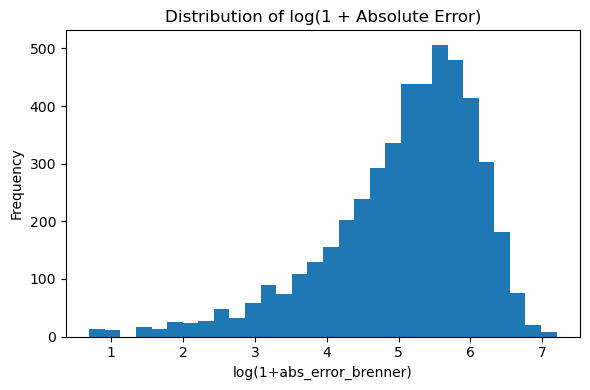

In [99]:
plt.figure(figsize=(6, 4))
plt.hist(y_log, bins=30)
plt.title("Distribution of log(1 + Absolute Error)")
plt.xlabel("log(1+abs_error_brenner)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

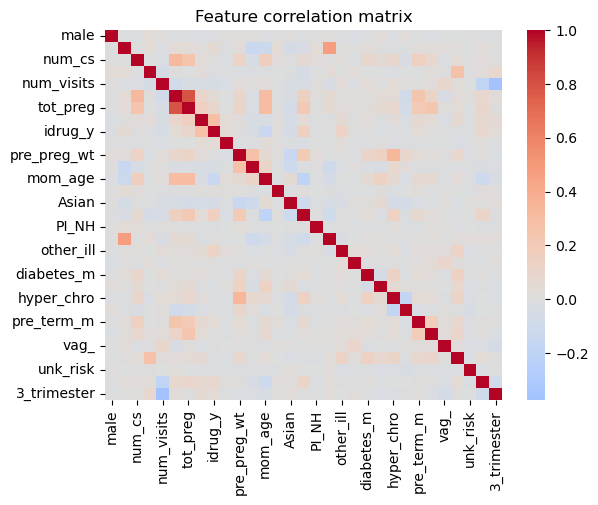

In [100]:
sns.heatmap(X_ols.corr(), cmap="coolwarm", center=0)
plt.title("Feature correlation matrix")
plt.show()

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd


vif_df = pd.DataFrame({
    "variable": X_const.columns,
    "VIF": [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

print(vif_df.sort_values("VIF", ascending=False))


       variable         VIF
0         const  618.595007
7      tot_preg    3.037183
6    live_livex    2.946232
11  pre_preg_wt    1.370467
13      mom_age    1.357249
2      hispanic    1.343795
18        Other    1.327460
16        Black    1.265158
5    num_visits    1.258431
23   hyper_chro    1.233352
31  3_trimester    1.217914
28   prelab_ref    1.166259
3        num_cs    1.162365
12       mom_ht    1.160706
9       idrug_y    1.157753
8     any_smoke    1.132277
30  2_trimester    1.118251
26    poor_preg    1.115486
25   pre_term_m    1.111342
4    none_congm    1.102434
24   hyper_preg    1.076414
22   diabetes_g    1.071454
21   diabetes_m    1.070160
15        Asian    1.064280
19    other_ill    1.047147
27         vag_    1.028472
20       abrupt    1.015286
10    num_drink    1.011246
29     unk_risk    1.009069
1          male    1.008113
17        PI_NH    1.007334
14         AIAN    1.006710


In [102]:
model   = sm.OLS(y_log, X_const).fit(cov_type="HC3")
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      abs_error_brenner   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.938
Date:                Wed, 16 Jul 2025   Prob (F-statistic):            0.00139
Time:                        11:30:38   Log-Likelihood:                -7037.6
No. Observations:                4766   AIC:                         1.414e+04
Df Residuals:                    4734   BIC:                         1.435e+04
Df Model:                          31                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0466      0.390     10.363      

In [103]:
# 1)  Assemble a DataFrame of coefficient, std-err, t, p
results_df = pd.DataFrame({
    "coef"   : model.params,
    "stderr" : model.bse,
    "t"      : model.tvalues,
    "pvalue" : model.pvalues
})

# 2)  Keep rows with p < 0.05  (or any threshold you like)
sig_df = results_df[results_df["pvalue"] < 0.05]

print(f"Significant variables (p < 0.05):  {sig_df.shape[0]} / {results_df.shape[0]}")
display(sig_df.sort_values("pvalue"))

Significant variables (p < 0.05):  7 / 32


,coef,stderr,t,pvalue
const,4.046631,0.390474,10.363386,3.638492e-25
hispanic,0.178605,0.065362,2.732540,6.284805e-03
pre_preg_wt,0.000987,0.000371,2.664804,7.703327e-03
mom_age,0.008672,0.003306,2.623017,8.715503e-03
num_cs,-0.088035,0.033612,-2.619118,8.815746e-03
num_visits,0.013343,0.006527,2.044213,4.093254e-02
diabetes_m,-0.214929,0.106961,-2.009417,4.449294e-02


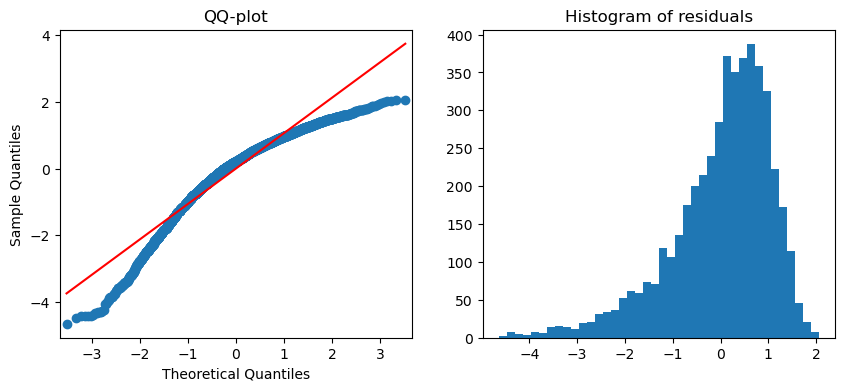

In [104]:
resid = model.resid       # 残差
fig, ax = plt.subplots(1,2, figsize=(10,4))
sm.qqplot(resid, line="s", ax=ax[0]); ax[0].set_title("QQ-plot")
ax[1].hist(resid, bins=40); ax[1].set_title("Histogram of residuals")
plt.show()


In [108]:
from sklearn.preprocessing import StandardScaler    # optional for scaling

# --------------------------------------------------
# 1)  Build the design matrix (same steps as OLS)
# --------------------------------------------------
X_gamma = X.copy()

bool_cols = X_gamma.select_dtypes(include="bool").columns
X_gamma[bool_cols] = X_gamma[bool_cols].astype(int)

X_gamma = X_gamma.apply(pd.to_numeric, errors="raise").astype(float)

# --- OPTIONAL: standardise continuous predictors to tame cond. number -----
#num_cols          = [c for c in X_gamma.columns if X_gamma[c].nunique() > 2]
#X_gamma[num_cols] = StandardScaler().fit_transform(X_gamma[num_cols])
# --------------------------------------------------------------------------

X_const = sm.add_constant(X_gamma)

# --------------------------------------------------
# 2)  Response vector — keep only positive y values 🔄
# --------------------------------------------------
y = merged["abs_error_brenner"].astype(float)

mask      = y > 0                # Gamma distribution requires y > 0
y_pos     = y[mask]
X_const   = X_const.loc[mask]     # drop same rows in X

# --------------------------------------------------
# 3)  Fit the Gamma GLM with a log link 🔄
# --------------------------------------------------
gamma_mod = sm.GLM(
    y_pos,
    X_const,
    family = sm.families.Gamma(sm.families.links.log())
).fit()                           # ➜ ML fit with default (Wald) SEs

#  -- robust SEs, if you want the HC3 flavour like in your OLS model:
# gamma_mod = sm.GLM(...).fit(cov_type="HC3")

print(gamma_mod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      abs_error_brenner   No. Observations:                 4766
Model:                            GLM   Df Residuals:                     4734
Model Family:                   Gamma   Df Model:                           31
Link Function:                    log   Scale:                         0.60295
Method:                          IRLS   Log-Likelihood:                -30672.
Date:                Wed, 16 Jul 2025   Deviance:                       3922.9
Time:                        11:37:04   Pearson chi2:                 2.85e+03
No. Iterations:                    14   Pseudo R-squ. (CS):            0.01657
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.6796      0.280     16.728      

In [109]:
res = gamma_mod                      # <- your fitted GLM results object

glm_df = pd.DataFrame({
    "coef"   : res.params,
    "stderr" : res.bse,
    "z"      : res.tvalues,          # for GLM, tvalues == z-values
    "pvalue" : res.pvalues
})

# Add 95 % CI bounds
ci_bounds = res.conf_int()                # returns an (n_params × 2) array
ci_bounds.columns = ["ci_lower", "ci_upper"]

# Merge with the original table
glm_df = pd.concat([glm_df, ci_bounds], axis=1)

# --------------------------------------------------
# 2️⃣  Keep only “significant” rows (p < 0.05)
# --------------------------------------------------
alpha   = 0.05
sig_df  = glm_df[glm_df["pvalue"] < alpha]

print(f"Significant variables (p < {alpha}): {sig_df.shape[0]} of {glm_df.shape[0]}")
display(sig_df.sort_values("pvalue"))

Significant variables (p < 0.05): 5 of 32


,coef,stderr,z,pvalue,ci_lower,ci_upper
const,4.679596,0.279748,16.727908,8.207082e-63,4.131300,5.227892
pre_preg_wt,0.001018,0.000263,3.864145,1.114790e-04,0.000502,0.001534
hispanic,0.128704,0.046707,2.755593,5.858585e-03,0.037161,0.220247
mom_age,0.005466,0.002473,2.210398,2.707752e-02,0.000619,0.010312
diabetes_m,-0.143414,0.070389,-2.037453,4.160463e-02,-0.281374,-0.005454


## Subanalysis

In [ ]:
df = merged.copy()

df["over_est"] = (df["error_brenner"] > 0).astype("int8")   

In [ ]:
# --- build design matrix ------------------------------------------------
X_bin = X.copy()

bool_cols        = X_bin.select_dtypes("bool").columns
X_bin[bool_cols] = X_bin[bool_cols].astype(int)

# optional scaling (skip columns with zero variance)
num_cols  = [c for c in X_bin.columns if X_bin[c].nunique() > 2]
from sklearn.preprocessing import StandardScaler
X_bin[num_cols] = StandardScaler().fit_transform(X_bin[num_cols])

# 1) drop strict-zero-variance columns (all identical values)
zero_var = X_bin.columns[X_bin.nunique() == 1]
X_bin    = X_bin.drop(columns=zero_var)

# 2) add a single constant column
X_bin = sm.add_constant(X_bin, has_constant='add')

# 3) force float64 and drop any rows with NaN
X_bin = X_bin.apply(pd.to_numeric, errors="raise").astype(float)
mask  = X_bin.notna().all(axis=1)
X_bin = X_bin.loc[mask]
y_bin = df.loc[mask, "over_est"].astype(int)


In [ ]:
import statsmodels.api as sm

logit_mod = sm.GLM(
    y_bin,
    X_bin,
    family = sm.families.Binomial(link=sm.families.links.logit())
).fit(cov_type="HC3")          # robust SEs
print(logit_mod.summary())

In [ ]:
# --- logit_mod is your fitted model ---------------------------------
res = logit_mod                         # rename for brevity

# 1)  Build a tidy summary frame
summary_df = pd.DataFrame({
    "coef"   : res.params,
    "stderr" : res.bse,
    "z"      : res.tvalues,             # GLM -> z-values
    "pvalue" : res.pvalues,
    "OR"     : np.exp(res.params)       # odds-ratio
})

# 2)  Optional: drop the intercept row
summary_df = summary_df.drop(index="const", errors="ignore")

# 3)  Keep only “significant” predictors
alpha    = 0.05                         # threshold
sig_df   = (summary_df
            .loc[summary_df["pvalue"] < alpha]
            .sort_values("pvalue"))

print(f"Significant factors (p < {alpha}): {sig_df.shape[0]}")
display(sig_df)

## Table 1

In [110]:
merged.shape

(4766, 233)

In [111]:
moms = merged[merged["abs_error_brenner"]!=0]   # 1 row per mother
total_n = len(moms)                           # new N for Table 1 header

print(f"Unique mothers (N) = {total_n:,}")

Unique mothers (N) = 4,766


In [112]:
var = moms["mom_age"]                 # ← just change this
miss_n   = var.isna().sum()
miss_pct = miss_n / total_n * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         30.4 (5.30)
Median [Min, Max]: 31.0 [15.0, 52.0]
Missing (n, %):      0 (0.0%)


In [113]:
# --------------------------------------------------
# 2)  Define the grouped race categories
race_groups = {
    "American Indian or Alaska Native": ["mom_aina"],
    "Asian":  [
        "mom_si", "mom_chi", "mom_fil",
        "mom_jap", "mom_kor", "mom_vie", "mom_oas"
    ],
    "Black":  ["mom_bla"],
    "Pacific Islander/Native Hawaiian": [
        "mom_nha", "mom_gua", "mom_sam", "mom_opi"
    ],
    "Other":  ["mom_oth"],
    "White":  ["mom_whi"],
}

# --------------------------------------------------
# 3)  Calculate counts & percentages
rows = []
for category, cols in race_groups.items():
    # any() is TRUE if the mother is flagged “1:Yes” in ANY of the columns in that group
    mask = moms[cols].eq(1).any(axis=1)
    count = int(mask.sum())
    pct   = round(100 * count / total_n, 1)
    rows.append({"Race Category": category,
                 "Count (Percent)": f"{count:,} ({pct}%)"})

race_table = pd.DataFrame(rows)
print(race_table.to_string(index=False))

                   Race Category Count (Percent)
American Indian or Alaska Native       37 (0.8%)
                           Asian      246 (5.2%)
                           Black   1,091 (22.9%)
Pacific Islander/Native Hawaiian        7 (0.1%)
                           Other      203 (4.3%)
                           White   3,336 (70.0%)


In [114]:
summary = (
    moms['mhis_no'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

       Category     n   pct
0  Not Hispanic  4360  91.5
1      Hispanic   406   8.5


In [115]:
summary = (
    moms['mom_educ'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

                           Category     n   pct
0               6:Bachelor's degree  1091  22.9
1         3:High School Grad or GED   973  20.4
2                 7:Master's degree   853  17.9
3  4:Some college credit, no degree   701  14.7
4                5:Associate degree   497  10.4
5      2:9th-12th grade, no diploma   298   6.3
6              8:Doctorate's degree   252   5.3
7                         9:Unknown    58   1.2
8               1:8th Grade or less    43   0.9


In [116]:
summary = (
    moms['mom_employ'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

  Category     n   pct
0    1:Yes  3365  70.6
1     0:No  1401  29.4


In [117]:
var = moms["tot_preg"]                 # ← just change this

miss_n   = var.isna().sum()
miss_pct = miss_n / total_n * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         1.8 (1.97)
Median [Min, Max]: 1.0 [0.0, 15.0]
Missing (n, %):      17 (0.4%)


In [118]:
var = moms["live_livex"]                 # ← just change this

miss_n   = var.isna().sum()
miss_pct = miss_n / total_n * 100

print(f"Mean (SD):         {var.mean():.1f} ({var.std(ddof=1):.2f})")
print(f"Median [Min, Max]: {var.median():.1f} [{var.min():.1f}, {var.max():.1f}]")
print(f"Missing (n, %):      {miss_n} ({miss_pct:.1f}%)")

Mean (SD):         1.0 (1.22)
Median [Min, Max]: 1.0 [0.0, 11.0]
Missing (n, %):      20 (0.4%)


In [119]:
summary = (
    moms['sex_of_inf'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(2))
)

print(summary)

   Category     n    pct
0    1:Male  2404  50.44
1  2:Female  2362  49.56


In [ ]:
#### # --------------------------------------------------
# 1)  Boolean flags (new column name : original raw column)
risk_map = {
    "abruptio_placenta"    : "abrupt",
    "diabetes_gestational" : "diabetes_g",
    "diabetes_prepreg"     : "diabetes_m",
    "hypertension_prepreg" : "hyper_chro",
    "hypertension_preg"    : "hyper_preg",
    "eclampsia"            : "eclampsiax",
    "infertility_treat"    : "inferti",
    "infert_med_flag"      : "infert_med",
    "infert_art_flag"      : "infert_art",
    "other_chronic"        : "other_ill",
    "poor_outcome"         : "poor_preg",
    "prelab_referral"      : "prelab_ref",
    "preterm_prev"         : "pre_term_m",
    "previous_cs"          : "prev_cs",
    "unknown_risk"         : "unk_risk",
    "vaginal_bleeding"     : "vag_"
}

for new, raw in risk_map.items():
    moms[new] = moms[raw].eq("1:Yes")

# --------------------------------------------------
# 2)  Pretty labels for the table
label_map = {
    "abruptio_placenta"    : "Abruptio Placenta",
    "diabetes_gestational" : "Diabetes, gestational",
    "diabetes_prepreg"     : "Diabetes, pre-pregnancy",
    "hypertension_prepreg" : "Hypertension, pre-pregnancy",
    "hypertension_preg"    : "Hypertension, pregnancy-related",
    "eclampsia"            : "Eclampsia",
    "infertility_treat"    : "Infertility Treatments",
    "infert_med_flag"      : "Infertility/Fertility Enhancing Drugs",
    "infert_art_flag"      : "Infertility/Assisted Reproductive Technology",
    "other_chronic"        : "Other Serious Chronic Diseases",
    "poor_outcome"         : "Poor pregnancy outcomes",
    "prelab_referral"      : "Pre-labor Referral for High Risk",
    "preterm_prev"         : "Pre-term infant, previous",
    "previous_cs"          : "Previous Cesarean Section",
    "unknown_risk"         : "Unknown",
    "vaginal_bleeding"     : "Vaginal bleeding"
}

# --------------------------------------------------
# 3)  Summarise (multiple responses allowed)
rows = []
for col in risk_map.keys():
    n   = int(moms[col].sum())
    pct = round(n / total_n * 100, 1)
    rows.append({
        "Pregnancy Risk Factor": label_map[col],
        "Count (Percent)"      : f"{n} ({pct}%)"
    })

risk_table = pd.DataFrame(rows).sort_values("Count (Percent)", ascending=False)
print(risk_table.to_string(index=False))


In [120]:
summary = (
    moms['none_medri'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

   Category     n   pct
0         1  3160  66.3
1         0  1606  33.7


In [121]:
summary = (
    moms['none_congm'].value_counts(dropna=False)     
        .rename_axis('Category')
        .reset_index(name='n')
        .assign(pct=lambda d: (d['n'] / len(moms) * 100).round(1))
)

print(summary)

   Category     n   pct
0         0  4622  97.0
1         1   144   3.0
